In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten,BatchNormalization
from tensorflow.keras.layers import Dense, MaxPooling2D
from tensorflow.keras.layers import Input,Activation
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import applications
from keras.callbacks import EarlyStopping

In [2]:
train = list(os.walk(r"C:\Users\78658\Documents\WEEK2\archive\Dataset\train")) 

In [3]:
label_names = train[0][1]
dict_labels = dict(zip(label_names, list(range(len(label_names)))))
print(dict_labels)

{'cloth': 0, 'n95': 1, 'n95v': 2, 'nfm': 3, 'srg': 4}


In [4]:
def dataset(path): 
    images = []
    labels = []
    for folder in os.listdir(path):
        value_of_label = dict_labels[folder] 

        for file in (os.listdir(os.path.join(path, folder))):
            path_of_file = os.path.join(os.path.join(path, folder), file)

            image = cv2.imread(path_of_file)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, (224, 224))
            images.append(image)
            labels.append(value_of_label)

    images = np.array(images, dtype = 'float32')/255.0
    labels = np.array(labels)

    return images, labels

images, labels = dataset(r"C:\Users\78658\Documents\WEEK2\archive\Dataset\train")
images, labels = shuffle(images, labels)

In [5]:
images.shape

(1956, 224, 224, 3)

In [6]:
labels.shape

(1956,)

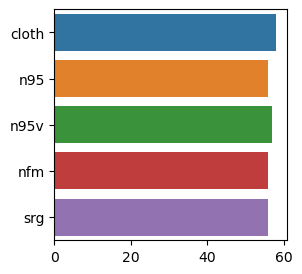

In [7]:
types_of_mask= train[0][1]
no_of_masks = []
for _ in range(1,6):
    no_of_masks.append(len(train[_][0]))
plt.figure(figsize = (3,3))
sns.barplot(y = types_of_mask, x = no_of_masks);

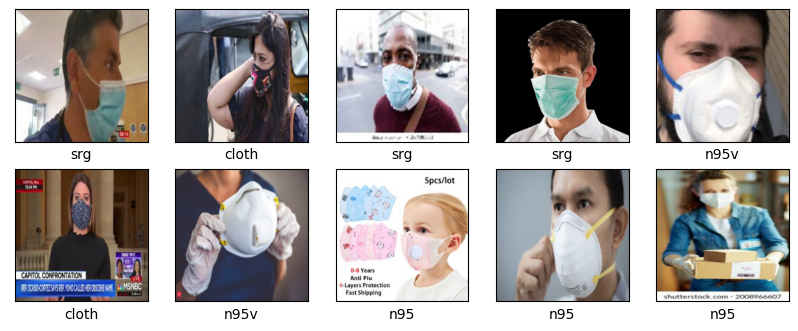

In [8]:
plt.figure(figsize = (10,10))
for _ in range(10):
    plt.subplot(5, 5, _+1)
    plt.yticks([])
    plt.xticks([])
    plt.grid(False)
    data = images[_]
    plt.xlabel(label_names[labels[_]])
    plt.imshow(data);

In [9]:
image_size = (224, 224)
batch_size = 32
train_datagen = ImageDataGenerator(rescale = 1./255,
                            shear_range = 0.4,        #Shear Intensity
                            zoom_range = 0.4,         #Range for random zoom
                            horizontal_flip = True,   #Randomly flip inputs horizontally. 
                            validation_split = 0.15,  #Fraction of images reserved for validation
                            rotation_range=20,        #Degree range for random rotations.    
                            width_shift_range=0.2,
                            height_shift_range=0.2)

In [10]:
train_ds = train_datagen.flow_from_directory(r"C:\Users\78658\Documents\WEEK2\archive\Dataset\train",
                                      target_size = image_size,
                                      batch_size = batch_size,
                                      class_mode = 'categorical',
                                      subset = 'training',
                                      color_mode="rgb")

val_ds = train_datagen.flow_from_directory(r"C:\Users\78658\Documents\WEEK2\archive\Dataset\test",
                                      target_size = image_size,
                                      batch_size = batch_size,
                                      class_mode = 'categorical',
                                      subset = 'validation',
                                      color_mode="rgb")

Found 1664 images belonging to 5 classes.
Found 47 images belonging to 5 classes.


In [11]:
train_ds.class_indices

{'cloth': 0, 'n95': 1, 'n95v': 2, 'nfm': 3, 'srg': 4}

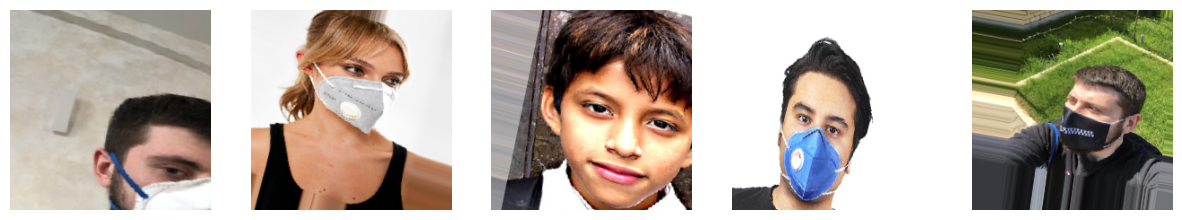

In [12]:
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(15,15))

for i in range(5):
    image = next(train_ds)[0][0]
    image = np.squeeze(image)
    ax[i].imshow(image)
    ax[i].axis(False)

#vgg16 

In [79]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Input, Dense, Activation, Flatten
from tensorflow.keras import Model

input_shape = (224, 224, 3)
input_layer = Input(shape=input_shape, name='input_layer')
m_model = VGG16(weights='imagenet', include_top=False, input_tensor=input_layer)
basem_output = m_model.layers[-1].output

x = Flatten()(basem_output)
x = Dense(128)(x)
x = Activation('relu')(x)
x = Dense(64)(x)
x = Activation('relu')(x)
final_output = Dense(5, activation='softmax')(x)

mob_model = Model(inputs=input_layer, outputs=final_output)


In [80]:
m_model.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Layer (type)                       ┃ Output Shape                  ┃     Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│ input_layer (InputLayer)           │ (None, 224, 224, 3)           │           0 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block1_conv1 (Conv2D)              │ (None, 224, 224, 64)          │       1,792 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block1_conv2 (Conv2D)              │ (None, 224, 224, 64)          │      36,928 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block1_pool (MaxPooling2D)         │ (None, 112, 112, 64)          │           0 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block2_conv1 (Conv2D)              │ (None, 112, 112, 128)         │      73,856 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block2_conv2 (Conv2D)              │ (None, 112, 112, 128)         │     147,584 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block2_pool (MaxPooling2D)         │ (None, 56, 56, 128)           │           0 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block3_conv1 (Conv2D)              │ (None, 56, 56, 256)           │     295,168 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block3_conv2 (Conv2D)              │ (None, 56, 56, 256)           │     590,080 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block3_conv3 (Conv2D)              │ (None, 56, 56, 256)           │     590,080 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block3_pool (MaxPooling2D)         │ (None, 28, 28, 256)           │           0 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block4_conv1 (Conv2D)              │ (None, 28, 28, 512)           │   1,180,160 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block4_conv2 (Conv2D)              │ (None, 28, 28, 512)           │   2,359,808 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block4_conv3 (Conv2D)              │ (None, 28, 28, 512)           │   2,359,808 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block4_pool (MaxPooling2D)         │ (None, 14, 14, 512)           │           0 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block5_conv1 (Conv2D)              │ (None, 14, 14, 512)           │   2,359,808 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block5_conv2 (Conv2D)              │ (None, 14, 14, 512)           │   2,359,808 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block5_conv3 (Conv2D)              │ (None, 14, 14, 512)           │   2,359,808 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ block5_pool (MaxPooling2D)         │ (None, 7, 7, 512)             │           0 │
└────────────────────────────────────┴───────────────────────────────┴─────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [81]:
mob_model.compile(loss="categorical_crossentropy",optimizer="sgd",metrics=["accuracy"])

In [82]:
early_stopping = EarlyStopping(
                          monitor='val_loss',      #Quantity to be monitored.
                          patience=2,              #Number of epochs with no improvement after which training will be stopped.  
                          verbose=1,               #displays messages when the callback takes an action.
                          restore_best_weights=True,#Whether to restore model weights from the epoch with the best value of the monitored quantity
                          mode="auto",)

callback = [early_stopping]

In [83]:
mob_hist=mob_model.fit(train_ds, epochs=15, validation_data=val_ds,callbacks=[callback])

Epoch 1/15


D:\Anaconda\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


52/52 ━━━━━━━━━━━━━━━━━━━━ 325s 6s/step - accuracy: 0.2406 - loss: 1.8525 - val_accuracy: 0.3404 - val_loss: 1.5040
Epoch 2/15
52/52 ━━━━━━━━━━━━━━━━━━━━ 396s 8s/step - accuracy: 0.3923 - loss: 1.4556 - val_accuracy: 0.2766 - val_loss: 1.6453
Epoch 3/15
52/52 ━━━━━━━━━━━━━━━━━━━━ 451s 9s/step - accuracy: 0.4647 - loss: 1.2599 - val_accuracy: 0.5745 - val_loss: 1.0947
Epoch 4/15
52/52 ━━━━━━━━━━━━━━━━━━━━ 452s 9s/step - accuracy: 0.6363 - loss: 0.9263 - val_accuracy: 0.7234 - val_loss: 0.8717
Epoch 5/15
52/52 ━━━━━━━━━━━━━━━━━━━━ 470s 9s/step - accuracy: 0.6892 - loss: 0.8350 - val_accuracy: 0.1489 - val_loss: 1.6237
Epoch 6/15
52/52 ━━━━━━━━━━━━━━━━━━━━ 464s 9s/step - accuracy: 0.3761 - loss: 1.4313 - val_accuracy: 0.7872 - val_loss: 0.5590
Epoch 7/15
52/52 ━━━━━━━━━━━━━━━━━━━━ 483s 9s/step - accuracy: 0.7641 - loss: 0.6381 - val_accuracy: 0.8298 - val_loss: 0.4789
Epoch 8/15
52/52 ━━━━━━━━━━━━━━━━━━━━ 472s 9s/step - accuracy: 0.8201 - loss: 0.4937 - val_accuracy: 0.2340 - val_loss: 1.

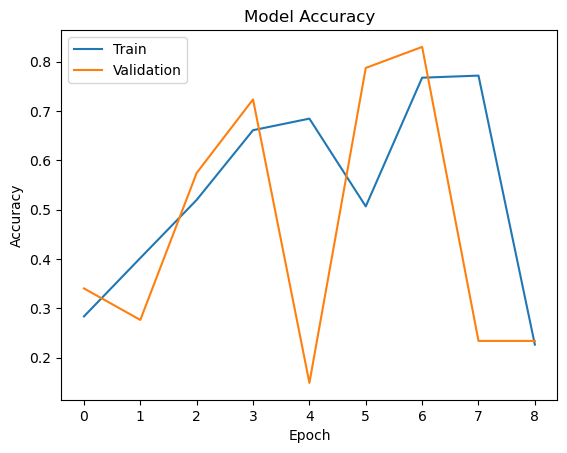

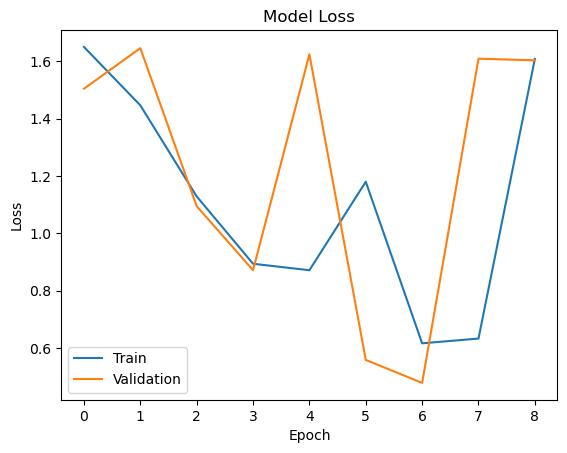

In [84]:
import matplotlib.pyplot as plt
plt.plot(mob_hist.history['accuracy'])
plt.plot(mob_hist.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc=0)
plt.show()


plt.plot(mob_hist.history['loss'])
plt.plot(mob_hist.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc=0)
plt.show()

In [85]:
def predictor(img, model):
    image = cv2.imread(img)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224, 224))
    image = np.array(image, dtype = 'float32')/255.0
    plt.imshow(image)
    image = image.reshape(1, 224,224,3)
    
    label_names = train_ds.class_indices
    dict_class = dict(zip(list(range(len(label_names))), label_names))
    clas = model.predict(image).argmax()
    name = dict_class[clas]
    print('The given image is of \nClass: {0} \nSpecies: {1}'.format(clas, name))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step
The given image is of 
Class: 1 
Species: n95


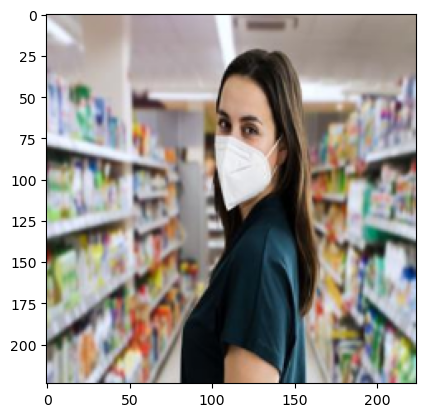

In [87]:
predictor(r"C:\Users\78658\Documents\WEEK2\archive\Dataset\test\n95\354.jpg", mob_model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
The given image is of 
Class: 3 
Species: nfm


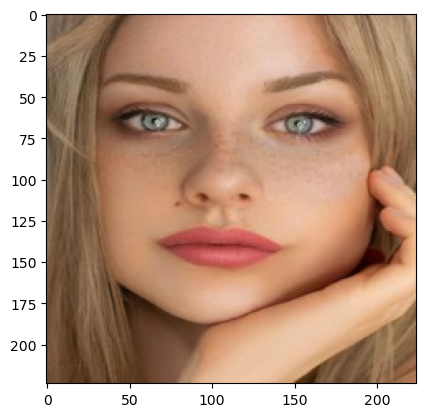

In [88]:
predictor(r"C:\Users\78658\Documents\WEEK2\archive\Dataset\test\nfm\2.jpg",mob_model)

In [89]:
mob_model.save('Face_Mask_Detection—VGG16.h5')

D:\Anaconda\lib\site-packages\keras\src\models\model.py:342: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  warnings.warn(


# ResNet101

In [1]:
from tensorflow.keras.applications import ResNet101

input_shape = (224, 224, 3)
input_layer = Input(shape=input_shape, name='input_layer')
m_model = ResNet101(weights='imagenet', include_top=False, input_tensor=input_layer)
basem_output = m_model.output

x = Flatten()(basem_output)
x = Dense(128, activation='relu')(x)
x = Dense(64, activation='relu')(x)
final_output = Dense(5, activation='softmax')(x)

resnet_model = Model(inputs=input_layer, outputs=final_output)


NameError: name 'Input' is not defined

In [14]:
resnet_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃     Param # ┃ Connected to                   ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 224, 224, 3)       │           0 │ -                              │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ conv1_pad (ZeroPadding2D)     │ (None, 230, 230, 3)       │           0 │ input_layer[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ conv1_conv (Conv2D)           │ (None, 112, 112, 64)      │       9,472 │ conv1_pad[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ conv1_bn (BatchNormalization) │ (None, 112, 112, 64)      │         256 │ conv1_conv[0][0]               │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ conv1_relu (Activation)       │ (None, 112, 112, 64)      │           0 │ conv1_bn[0][0]                 │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ pool1_pad (ZeroPadding2D)     │ (None, 114, 114, 64)      │           0 │ conv1_relu[0][0]               │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ pool1_pool (MaxPooling2D)     │ (None, 56, 56, 64)        │           0 │ pool1_pad[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ conv2_block1_1_conv (Conv2D)  │ (None, 56, 56, 64)        │       4,160 │ pool1_pool[0][0]               │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ conv2_block1_1_bn             │ (None, 56, 56, 64)        │         256 │ conv2_block1_1_conv[0][0]      │
│ (BatchNormalization)          │                           │             │                                │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ conv2_block1_1_relu           │ (None, 56, 56, 64)        │           0 │ conv2_block1_1_bn[0][0]        │
│ (Activation)                  │                           │             │                                │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ conv2_block1_2_conv (Conv2D)  │ (None, 56, 56, 64)        │      36,928 │ conv2_block1_1_relu[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ conv2_block1_2_bn             │ (None, 56, 56, 64)        │         256 │ conv2_block1_2_conv[0][0]      │
│ (BatchNormalization)          │                           │             │                                │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ conv2_block1_2_relu           │ (None, 56, 56, 64)        │           0 │ conv2_block1_2_bn[0][0]        │
│ (Activation)                  │                           │             │                                │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ conv2_block1_0_conv (Conv2D)  │ (None, 56, 56, 256)       │      16,640 │ pool1_pool[0][0]               │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ conv2_block1_3_conv (Conv2D)  │ (None, 56, 56, 256)       │      16,640 │ conv2_block1_2_relu[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────┼─

 Total params: 55,511,941 (211.76 MB)

 Trainable params: 55,406,597 (211.36 MB)

 Non-trainable params: 105,344 (411.50 KB)

In [15]:
resnet_model.compile(loss="categorical_crossentropy",optimizer="sgd",metrics=["accuracy"])

In [16]:
early_stopping = EarlyStopping(
                          monitor='val_loss',      #Quantity to be monitored.
                          patience=2,              #Number of epochs with no improvement after which training will be stopped.  
                          verbose=1,               #displays messages when the callback takes an action.
                          restore_best_weights=True,#Whether to restore model weights from the epoch with the best value of the monitored quantity
                          mode="auto",)

callback = [early_stopping]

In [17]:
m_hist=resnet_model.fit(train_ds, epochs=10, validation_data=val_ds,callbacks=[callback])

Epoch 1/10


D:\Anaconda\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


52/52 ━━━━━━━━━━━━━━━━━━━━ 332s 6s/step - accuracy: 0.3808 - loss: 3.5539 - val_accuracy: 0.2553 - val_loss: 1.8638
Epoch 2/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 342s 7s/step - accuracy: 0.7752 - loss: 0.6101 - val_accuracy: 0.2340 - val_loss: 3.7432
Epoch 3/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 336s 6s/step - accuracy: 0.8644 - loss: 0.3993 - val_accuracy: 0.1489 - val_loss: 2.2697
Epoch 3: early stopping
Restoring model weights from the end of the best epoch: 1.


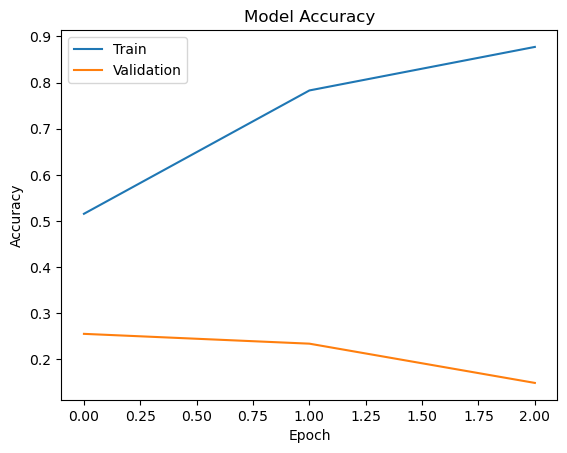

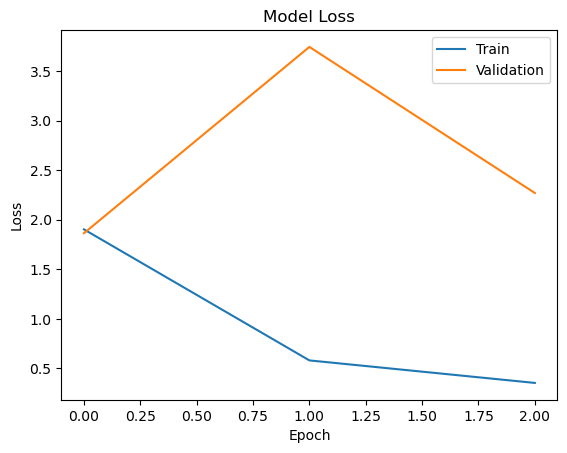

In [18]:
import matplotlib.pyplot as plt
plt.plot(m_hist.history['accuracy'])
plt.plot(m_hist.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc=0)
plt.show()


plt.plot(m_hist.history['loss'])
plt.plot(m_hist.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc=0)
plt.show()

In [19]:
def predictor(img, model):
    image = cv2.imread(img)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224, 224))
    image = np.array(image, dtype = 'float32')/255.0
    plt.imshow(image)
    image = image.reshape(1, 224,224,3)
    
    label_names = train_ds.class_indices
    dict_class = dict(zip(list(range(len(label_names))), label_names))
    clas = model.predict(image).argmax()
    name = dict_class[clas]
    print('The given image is of \nClass: {0} \nSpecies: {1}'.format(clas, name))

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
The given image is of 
Class: 3 
Species: nfm


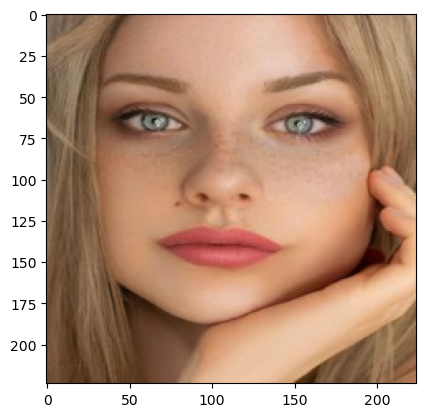

In [20]:
predictor(r"C:\Users\78658\Documents\WEEK2\archive\Dataset\test\nfm\2.jpg",resnet_model)

In [22]:
resnet_model.save('Face_Mask_Detection—ResNet101.h5')

D:\Anaconda\lib\site-packages\keras\src\models\model.py:342: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  warnings.warn(
